In [27]:
import scipy.io
import pandas as pd
import numpy as np

In [28]:
from google.colab import drive
drive.mount('/content/drive')
data = scipy.io.loadmat('/content/drive/My Drive/ASSIGNMENT 2/data5.mat')

Mounted at /content/drive


In [32]:
print("keys of data is: ",data.keys())
data1 = data['x']
raw_data = pd.DataFrame(data1)                        ## converting data in dataframe
shuffled_raw_data = raw_data.sample(frac = 1, random_state = 7).reset_index(drop = True)       ## shuffling the data
shuffled_raw_data

keys of data is:  dict_keys(['__header__', '__version__', '__globals__', 'x'])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,9099.953116,34419.448400,12591.255480,18620.63712,2235.504601,21229.006820,41680.596380,169002.68050,138099.53810,57612.230960,34726.49806,39607.64698,5323.474615,13604.667440,5951.954708,7974.739527,2237.335039,8448.910441,23936.350210,133431.520600,155575.976700,107683.503600,61838.826250,29891.720930,5475.708579,27683.725520,9131.006312,14294.826350,378.942691,17040.588260,20001.756930,27563.001210,10706.739530,11551.853070,31962.063880,44190.886680,140.425265,1686.212907,1170.732378,619.270179,233.419546,1392.763022,1352.246639,949.346357,628.484465,761.633959,1049.815959,1049.514045,7.383080,4.258683,0.236529,0.086332,0.018593,0.001531,6.404204,5.475822,0.094963,0.008202,0.001600,0.000201,9.674465,2.166467,0.123968,0.018160,0.001644,0.000235,6.218616,3.728230,1.601582,0.303282,0.105261,0.020237,1.0
1,18545.804850,25605.492620,1668.275131,21654.12498,3677.349642,8999.087928,9256.006177,42351.82393,113792.73200,147831.651500,38208.38922,23759.13748,70.926836,325.233172,204.617607,146.981798,55.940062,246.419514,172.899231,290.023958,334.614121,246.616247,132.662535,93.254131,46.411854,72.470217,17.783717,55.164717,13.881040,33.591979,152.008318,126.268650,149.235183,153.398953,26.056361,21.665645,15.070310,30.545217,21.154777,17.599012,10.683676,21.879826,58.675889,113.320786,137.386084,71.483439,10.963912,3.127098,10.770977,1.030099,0.130368,0.042568,0.008751,0.001430,6.568659,3.478885,1.194281,0.529476,0.144836,0.046084,6.579068,2.341549,1.910509,0.632260,0.426809,0.050869,5.923631,3.121233,1.643689,0.701598,0.360398,0.140074,1.0
2,31221.136800,33857.898070,23264.267890,26745.16991,18819.132370,20747.693070,42013.266020,207522.64490,368593.94770,300048.260500,86212.35524,42020.56924,14774.811680,13097.833620,10953.788620,11195.764020,9589.574397,8334.849935,9219.566785,54437.925070,163425.753600,149318.424400,43064.687870,20234.164220,3369.003452,2891.060212,8776.026715,935.736450,5348.907707,4988.279668,1031.122915,13168.617970,26675.599890,22079.425240,4689.063298,2570.127057,260.571928,129.208638,354.222658,106.579161,275.271695,177.076403,138.148470,1646.457433,9879.343442,4921.108812,648.755982,267.029548,7.243279,4.441496,0.261800,0.033213,0.003865,0.001204,7.545151,4.363245,0.063260,0.011169,0.001451,0.000555,6.635780,4.910883,0.331001,0.083566,0.013873,0.006454,5.590924,3.257021,2.180618,0.471013,0.321156,0.098357,0.0
3,6045.378272,14044.801660,2527.740590,9413.66631,776.165541,6775.022914,8910.421889,41152.93675,40404.93494,30671.588110,19607.00581,11707.26269,4789.204676,7974.068580,605.009777,6229.019951,702.279665,3094.723793,11893.737390,18634.390280,8667.826605,8893.405255,15367.260330,11971.061250,5556.483432,6670.662274,1177.852511,5817.669696,1698.620222,2535.872109,869.842833,8430.694269,29986.633430,35603.419470,19560.924780,8704.744766,1803.954962,1209.437443,175.474510,1461.781488,687.649243,241.326257,528.775380,1144.655228,6010.970293,5662.994658,2758.658408,1105.024611,8.751960,2.599051,0.350896,0.222692,0.045891,0.011647,9.054824,2.375603,0.482899,0.062145,0.006351,0.002155,8.748672,2.653536,0.534616,0.042858,0.003393,0.001397,4.971711,4.153662,1.528452,0.991325,0.277555,0.029828,0.0
4,11386.552440,80965.113360,42101.232220,35655.30042,6504.796850,58693.062770,86640.185320,212875.78110,259075.16610,292543.567800,150141.64130,66682.74558,2013.494527,38374.776620,31966.448790,12200.450210,7404.332221,34655.950730,72994.163430,115603.551100,74015.263860,60713.515000,49672.417780,37582.076790,5611.244812,8596.638592,2105.744716,6581.176581,1713.984335,3948.193590,6790.586865,24190.739750,82749.580770,183452.744600,67427.367650,14172.090300,571.767668,2710.909555,950.328805,1403.394543,84.256924,1687.375244,2069.385398,963.264914,5683.638423,21392.870840,8698.302270,2097.234749,7.981432,3.68923

In [76]:
### separating input (X) and labels (Y)
X = shuffled_raw_data.iloc[:,:-1]
Y = shuffled_raw_data.iloc[:,-1:]
Y.columns = list(range(Y.shape[1]))
print("shape of X is: ",X.shape)
print("shape of Y is: ",Y.shape)

shape of X is:  (2148, 72)
shape of Y is:  (2148, 1)


In [80]:
def elm(X_train, Y_train, num_hidden_neurons, seed):
  '''
  X_train: normalized training data ---- shape is (num_samples, num_features)
  Y_train: one hot encoded Y labels ---- shape is (num_samples, num_classes)
  num_hidden_neurons: number of neurons in hidden layer
  seed: same matrix is initialized everytime

  return:
  V: weight matrix between input and hidden layer ----- shape (num_features, num_hidden_neurons)
  b: bias vector of hidden layer ------ shape (1, num_hidden_neurons)
  W: weight matrix between hidden layer and output layer
  '''
  np.random.seed(seed)
  num_features = X_train.shape[1]                          ## number of features
  V = np.random.randn(num_features, num_hidden_neurons)    ## initializing a matrix
  b = np.random.randn(1, num_hidden_neurons)               ## initializing a bias vector
  hypo = np.dot(X_train, V) + b                            ## hypo = X_train*V + b
  H = np.tanh(hypo)                                        ## tanh activation 
  p_inv = np.linalg.pinv(H)                                ## pseudo-inverse of a matrix
  W = np.dot(p_inv, Y_train)                               ## weight matrix

  return V, b, W

In [51]:
def one_hot_encoding(Y):
  '''
  Y: output labels

  returns:
  one hot encoding of Y ---- shape (num_samples, num_classes)
  '''
  Y_hot = pd.get_dummies(Y[0]).to_numpy()
  return Y_hot

In [59]:
## function to normalize data ##
def normalize(D, min_features, max_features):
  Z = np.empty(D.shape)
  for i in range(D.shape[1]):
    Z[:,i] = (D[:,i] - min_features[i])/(max_features[i] - min_features[i])
  return Z

In [100]:
def calculate_accuracy(Y_act, Y_pred):
  tp = tn = fn = fp = 0
  Y_act[0] = Y_act[0].astype(int)
  
  for i in range(len(Y_act)):
    if(Y_act.iloc[i,0] == 0):
      if(Y_pred.iloc[i,0] == 0):
        tp = tp + 1
      else:
        fn = fn + 1

    else:
      if(Y_pred.iloc[i,0] == 0):
        fp = fp + 1
      else:
        tn = tn + 1
  
  accuracy = (tp + tn)/len(Y_act)
  return accuracy

In [124]:
#### k fold cross validation
def k_cross_validation(X, Y, k, num_hidden_layer_neurons):
  '''
  X and Y: input and output
  k: number of sets in which input should be divided
  '''
  a = 0
  b = round(len(Y)/k)
  Y_hot_enc = one_hot_encoding(Y)
  X_arr = X.to_numpy()

  accuracy = []

  for i in range(k):
    if(i != k-1):                                                     ### splitting the data in train and test set
      X_ts = X_arr[a:b, :]
      Y_ts = Y.iloc[a:b, :].reset_index(drop = True)
      X_tr = np.concatenate((X_arr[:a,:], X_arr[b:,:]), axis = 0)
      Y_tr = np.concatenate((Y_hot_enc[:a,:], Y_hot_enc[b:,:]), axis = 0)

    else:                                                             ### handling the last case, if num_samples is not divisible by k
      X_ts = X_arr[a:,:] 
      Y_ts = Y.iloc[a:,:].reset_index(drop = True)
      X_tr = X_arr[:a,:]
      Y_tr = Y_hot_enc[:a,:]

    min_X = list(X_tr.min(axis = 0))                              # min value of features of training data
    max_X = list(X_tr.max(axis = 0))                              # max value of features of training data

    X_tr_norm = normalize(X_tr, min_X, max_X)                     # normalising training and test data
    X_ts_norm = normalize(X_ts, min_X, max_X)

    V1, b1, W1 = elm(X_tr_norm, Y_tr, num_hidden_neurons = num_hidden_layer_neurons, seed = 1)    ### training the elm model
    hypo = np.dot(X_ts_norm, V1) + b1                          ### hypo of test data ------ X_ts * V + b --- shape (num_samples_test, num_hidden_neurons) 
    H = np.tanh(hypo)                                          ### calculating H matrix using tanh activation
    Yp = np.dot(H, W1)                                         ### calculating predictions
    Y_pred = pd.DataFrame(Yp.argmax(axis = 1))                 ### decoding predictions --- (converting to labels like 1,2,...)
    acc = calculate_accuracy(Y_ts, Y_pred)
    print("Accuracy in iteration %d is %.2f" %(i, acc*100)+ " %")
    accuracy.append(acc)
    a = a + round(len(Y)/k)
    b = b + round(len(Y)/k)
  #av_accuracy = sum(accuracy)/len(accuracy)
  #return av_accuracy

In [126]:
k_cross_validation(X, Y, 5, num_hidden_layer_neurons=397)

Accuracy in iteration 0 is 89.77 %
Accuracy in iteration 1 is 92.09 %
Accuracy in iteration 2 is 91.86 %
Accuracy in iteration 3 is 92.33 %
Accuracy in iteration 4 is 96.03 %


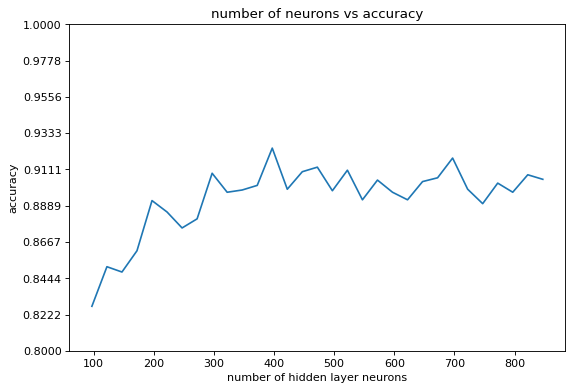

In [121]:
##### OPTIONAL CODE #####
'''
for the optional code
commenting out the print line in k_cross_validation function to avoid unnecesary print statements
''' 
import matplotlib.pyplot as plt

neurons = list(range(X.shape[1]+25, X.shape[1]+800, 25))
Accuracy = []
for i in range(len(neurons)):
  Acc = k_cross_validation(X, Y, 5, num_hidden_layer_neurons=neurons[i])
  Accuracy.append(Acc)
plt.figure(figsize=(8,200), dpi=80)
plt.subplot(len(neurons),1, 1)
plt.xlabel('number of hidden layer neurons')
plt.ylabel('accuracy')
plt.ylim(0.8, 1.0)
plt.yticks(np.linspace(0.8,1.0,10))
plt.title('number of neurons vs accuracy')
plt.plot(neurons, Accuracy)
plt.show()

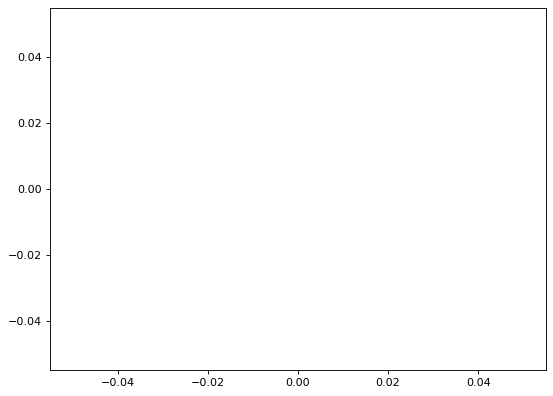

In [113]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot()
plt.show()